
# ISM Polarization Toy Model (8×8×8) — Heavily Commented
**Purpose:** a compact, editable Jupyter notebook that generates a toy 3D cube (8×8×8) containing Stokes **Q** and **U** per voxel, an intrinsic plane-of-sky (POS) wave pattern in polarization angle, line-of-sight (LOS) turbulence that perturbs the polarization angle creating depolarization on integration, a constant LOS (Z) magnetic field for Zeeman measurements, and a simple DCF (Chandrasekhar–Fermi) estimate of the POS magnetic field strength from angular dispersion.


The notebook is intentionally heavily commented and organized into sections so you can quickly adjust parameters, replace turbulence models, export results (FITS), or adapt physics.


In [138]:
import numpy as np
import matplotlib.pyplot as plt


In [139]:
# === USER-ADJUSTABLE PARAMETERS ===
# Grid size
nx, ny, nz = 16, 16, 16   # small example cube; change these to increase resolution (beware runtime)

# Intensity and intrinsic polarization fraction
I0 = 1.0               # intensity per voxel (constant here)

# POS pattern parameters
frequency = 1.0        # frequency of the sinusoidal variation across the POS
amplitude = 1.0        # amplitude of the sinusoidal variation across the POS

# LOS (Zeeman) magnetic field (true value) and measurement noise
Bz_true = 5.0          # true LOS B-field (arbitrary units, e.g., microgauss) - constant here
zeeman_noise_sigma = 0.3  # Gaussian noise added to simulated Zeeman "measurement"

# Turbulence along LOS: controls angular perturbations (radians)
turb_sigma = 0.1       # larger -> stronger angular perturbations -> more depolarization
corr_r = 0.8         # AR(1) correlation coefficient along the z-axis (0 = white; close to 1 = highly correlated)

# DCF parameters (arbitrary units). For physical units, set rho and sigma_v appropriately.
rho = 1.0              # mass density (set to 1 for toy model)
sigma_v = 1.0          # LOS velocity dispersion (required by DCF formula)
cf_prefactor = np.sqrt(4 * np.pi * rho) * sigma_v


### Build POS wavy magnetic field

In [ ]:
x = np.linspace(-np.pi, np.pi, nx)
y = np.linspace(-np.pi, np.pi, ny)
z = np.linspace(-np.pi, np.pi, nz)
X, Y, Z = np.meshgrid(x, y, z, indexing='xy')

# Mean POS field direction (single wave in x)
theta0 = amplitude * np.cos(frequency * X)

Bx0 = np.cos(theta0)
By0 = np.sin(theta0)
Bz0 = np.ones_like(Bx0) * Bz_true

### LOS turbulence as random rotation of POS field

In [ ]:
delta_theta = np.zeros((nx, ny, nz))

for ix in range(nx):
    for iy in range(ny):
        val = np.random.normal(scale=turb_sigma)
        for iz in range(nz):
            delta_theta[ix, iy, iz] = val
            val = corr_r * val + np.random.normal(
                scale=turb_sigma * np.sqrt(1 - corr_r**2))

# Apply turbulence: rotate POS components
Bx = Bx0 * np.cos(delta_theta) - By0 * np.sin(delta_theta)
By = Bx0 * np.sin(delta_theta) + By0 * np.cos(delta_theta)
Bz = Bz0  # LOS field unaffected by angular turbulence

### Compute Stokes and Polarization Observables

In [147]:
# === COMPUTE STOKES q, u FROM MAGNETIC FIELD ===
cos2g         = (Bx**2+By**2)/(Bx**2+By**2+Bz**2) # geometrical depolarization
q             = (By**2-Bx**2)/(Bx**2+By**2) * cos2g # Local (unnormalized) Stokes parameters
u             = (2*Bx*By)/(Bx**2+By**2) * cos2g # Local (unnormalized) Stokes parameters

# Include intensity scaling
Q3 = I0 * q
U3 = I0 * u

# === INTEGRATE ALONG LOS ===
Q_obs = Q3.sum(axis=2)
U_obs = U3.sum(axis=2)
I_obs = I0 * nz

# === OBSERVED POLARIZATION PROPERTIES ===
P_obs   = np.sqrt(Q_obs**2 + U_obs**2) / I_obs  # fractional polarization after LOS integration
phi_obs = 0.5 * np.arctan2(U_obs, Q_obs)        # observed polarization angle (radians)


### Add Zeeman information BLOS

In [ ]:
# === SIMULATED ZEEMAN MEASUREMENTS (LOS B) ===
Bz_map = np.ones((nx, ny)) * Bz_true
# add noise to measurement
Bz_measured = Bz_map + np.random.normal(scale=zeeman_noise_sigma, size=(nx, ny)) 

### DCF (Chandrasekhar-Fermi) estimate of POS field

In [148]:
# Estimate the local angular dispersion sigma_phi from a 3x3 patch of phi_obs around each pixel.
def angular_dispersion(angle_patch):
    """Compute angular dispersion for polarization angles (radians).
    Angles are treated with polarization periodicity (180 deg -> use 2*phi on the circle).
    Returns sigma_phi in radians."""
    a = angle_patch.flatten()
    cx = np.cos(2*a)
    sx = np.sin(2*a)
    C = np.mean(cx)
    S = np.mean(sx)
    R = np.sqrt(C**2 + S**2)
    R = np.clip(R, 1e-8, 1.0)
    sigma = 0.5 * np.sqrt(-2.0 * np.log(R))
    return sigma

# Compute sigma_phi map using a wrapped padding (toroidal) to avoid edge issues for small boxes
pad = 1
phi_padded = np.pad(phi_obs, pad_width=pad, mode='wrap')
sigma_phi_map = np.zeros((nx, ny))
for ix in range(nx):
    for iy in range(ny):
        patch = phi_padded[ix:ix+3, iy:iy+3]
        sigma_phi_map[ix, iy] = angular_dispersion(patch)

# Clip sigma to avoid division by zero and then compute DCF Bpos
sigma_floor = 1e-2
sigma_phi_map_clipped = np.clip(sigma_phi_map, sigma_floor, None)
Bpos_map = cf_prefactor / sigma_phi_map_clipped


### Plot 3D Field

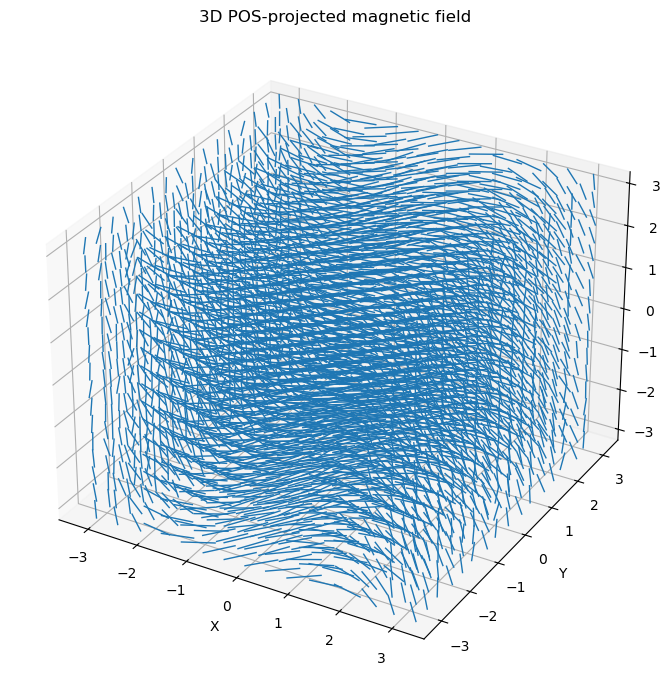

In [150]:
# --- POS-projected magnetic field per voxel ---
# Project B onto POS and apply geometric depolarization
Bx_pos = Bx * cos2g
By_pos = By * cos2g

# Normalize for visualization only (orientation matters, not magnitude)
norm = np.sqrt(Bx_pos**2 + By_pos**2)
norm[norm == 0] = 1.0
Bx_plot = Bx_pos /norm
By_plot = By_pos / norm
Bz_plot = np.zeros_like(Bx_plot)  # POS only

# Subsample for clarity (optional)
step = 1  # increase to thin vectors
Xs = X[::step, ::step, ::step]
Ys = Y[::step, ::step, ::step]
Zs = Z[::step, ::step, ::step]

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

ax.quiver(
    Xs, Ys, Zs,
    Bx_plot[::step, ::step, ::step],
    By_plot[::step, ::step, ::step],
    Bz_plot[::step, ::step, ::step],
    length=0.6,
    arrow_length_ratio=0.0,   # <-- headless vectors
    pivot='middle',
    linewidth=1
)

ax.set_title("3D POS-projected magnetic field")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.tight_layout()
plt.show()


### Plot slice of POS

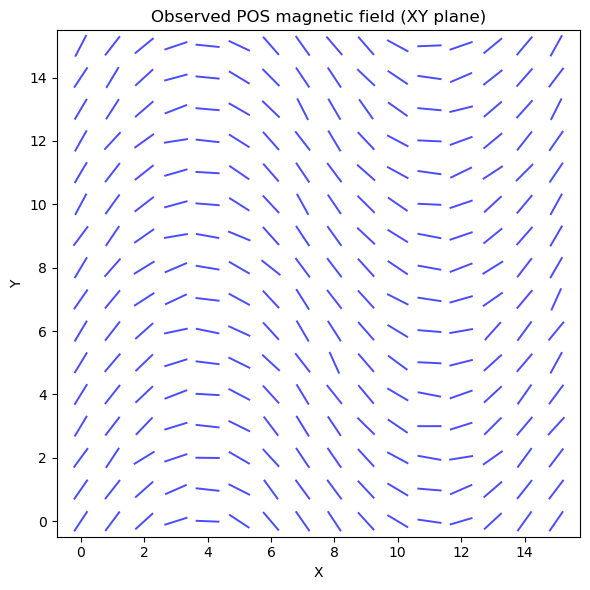

In [151]:
# Observed polarization angle
phi_pol = 0.5 * np.arctan2(U_obs, Q_obs)

# Convert to magnetic-field orientation
phi_B = phi_pol + np.pi / 2

# POS magnetic field components inferred from observables
Bx_obs = P_obs * np.cos(phi_B)
By_obs = P_obs * np.sin(phi_B)

ix = np.arange(nx)
iy = np.arange(ny)
XX, YY = np.meshgrid(ix, iy, indexing='xy')

plt.figure(figsize=(6, 6))

plt.quiver(XX, YY, Bx_obs, By_obs, angles='xy', scale_units='xy', scale=.05, pivot='middle',
    headwidth=0, headlength=0, headaxislength=0, linewidth=1, color='blue', alpha=0.7)

plt.title("Observed POS magnetic field (XY plane)")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.tight_layout()
plt.show()


### Plot maps of observables

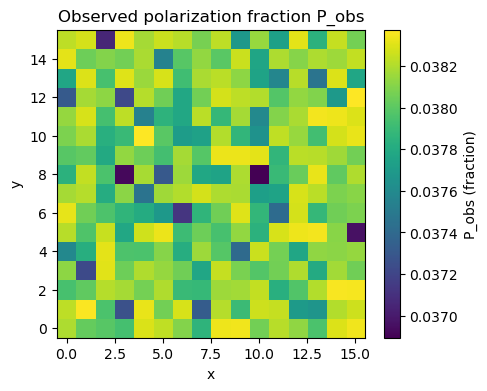

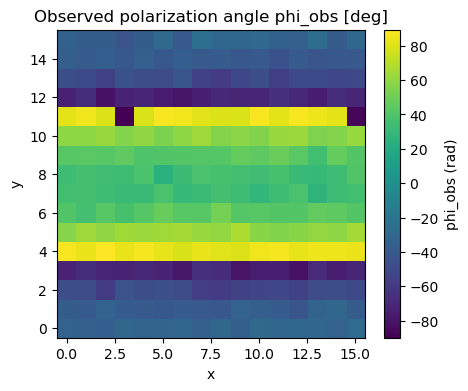

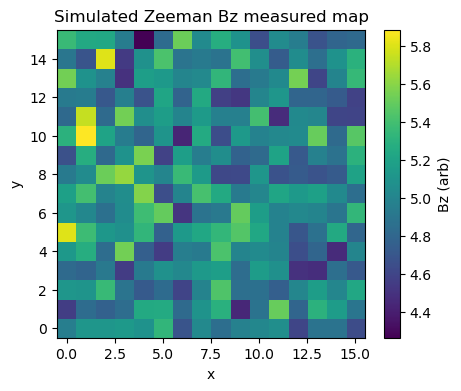

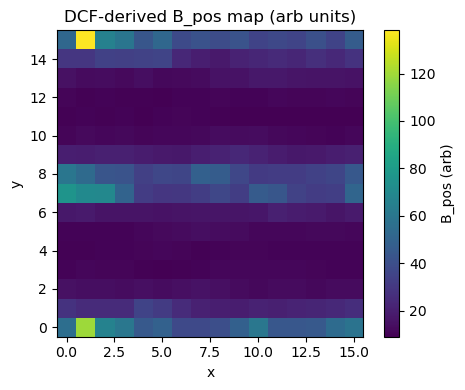

In [153]:

# === PLOTTING: a few diagnostic panels ===
# Each plot is on its own figure to keep things simple and readable.

plt.figure(figsize=(5,4))
plt.title('Observed polarization fraction P_obs')
plt.imshow(P_obs.T, origin='lower', interpolation='nearest', aspect='equal')
plt.colorbar(label='P_obs (fraction)'); plt.xlabel('x'); plt.ylabel('y')

plt.figure(figsize=(5,4))
plt.title('Observed polarization angle phi_obs [deg]')
plt.imshow(phi_obs.T*(180/np.pi), origin='lower', interpolation='nearest', aspect='equal')
plt.colorbar(label='phi_obs (rad)'); plt.xlabel('x'); plt.ylabel('y')

plt.figure(figsize=(5,4))
plt.title('Simulated Zeeman Bz measured map')
plt.imshow(Bz_measured.T, origin='lower', interpolation='nearest', aspect='equal')
plt.colorbar(label='Bz (arb)'); plt.xlabel('x'); plt.ylabel('y')

plt.figure(figsize=(5,4))
plt.title('DCF-derived B_pos map (arb units)')
plt.imshow(Bpos_map.T, origin='lower', interpolation='nearest', aspect='equal')
plt.colorbar(label='B_pos (arb)'); plt.xlabel('x'); plt.ylabel('y')

plt.tight_layout()
plt.show()


In [146]:

# === INSPECT, EXAMPLE OUTPUTS, AND OPTIONAL SAVES ===
# Print summary parameters for quick inspection
print('Grid:', nx, ny, nz)
print('Polarization Fraction:', P_obs)
print('Turbulence sigma (rad):', turb_sigma, 'corr_r:', corr_r)
print('True LOS Bz:', Bz_true, 'Zeeman noise sigma:', zeeman_noise_sigma)
print('DCF prefactor (sqrt(4*pi*rho)*sigma_v):', cf_prefactor)

# Example: show the per-layer phi_total and Q/U for the center LOS
cx, cy = nx//2, ny//2
print('\nCenter LOS per-layer phi_total and Q/U:')
for iz in range(nz):
    print(f'z={iz:2d}: phi={phi_obs[cx, cy, iz]:+.3f}, Q={Q3[cx, cy, iz]:+.4f}, U={U3[cx, cy, iz]:+.4f}')

print('\nObserved (integrated) at center pixel:')
print(f'Q_obs={Q_obs[cx,cy]:.4f}, U_obs={U_obs[cx,cy]:.4f}, P_obs={P_obs[cx,cy]:.4f}, phi_obs={phi_obs[cx,cy]:.3f} rad')

# # Optional: save cube to a multi-extension FITS file (requires astropy)
# def save_to_fits(filename='ism_polarization_cube.fits', overwrite=True):
#     """Saves a multi-extension FITS with Q3, U3, phi_total, Bz_map (per-plane) and metadata."""
#     hdu_primary = fits.PrimaryHDU()
#     hdul = fits.HDUList([hdu_primary])
#     hdul.append(fits.ImageHDU(Q3.astype(np.float32), name='Q3'))
#     hdul.append(fits.ImageHDU(U3.astype(np.float32), name='U3'))
#     hdul.append(fits.ImageHDU(phi_total.astype(np.float32), name='PHI_TOTAL'))
#     hdul.append(fits.ImageHDU(Bz_map.astype(np.float32), name='Bz_TRUE'))
#     # Save also observed 2D maps as separate HDUs
#     hdul.append(fits.ImageHDU(Q_obs.astype(np.float32), name='Q_OBS'))
#     hdul.append(fits.ImageHDU(U_obs.astype(np.float32), name='U_OBS'))
#     hdul.append(fits.ImageHDU(P_obs.astype(np.float32), name='P_OBS'))
#     hdul.append(fits.ImageHDU(Bpos_map.astype(np.float32), name='BPOS_DCF'))
#     hdul.writeto(filename, overwrite=overwrite)
#     print('Saved FITS to', filename)

# # Uncomment to save automatically
# # save_to_fits('/mnt/data/ism_polarization_cube.fits')


Grid: 16 16 16
Polarization Fraction: [[0.03819142 0.03822809 0.03794618 0.03812172 0.03758253 0.03821359
  0.03832232 0.03817335 0.03784611 0.03798973 0.03808213 0.03813986
  0.03731166 0.03777042 0.03831427 0.0382256 ]
 [0.03802803 0.03836774 0.03801325 0.03722346 0.03782456 0.03796506
  0.0380527  0.03821339 0.03824    0.03801821 0.03818516 0.03828841
  0.03817638 0.03829919 0.03805125 0.03828044]
 [0.03798901 0.03795411 0.03821151 0.03831169 0.03831431 0.03825358
  0.03796238 0.03780928 0.03795655 0.03779439 0.03782918 0.03794008
  0.03812634 0.03794386 0.03809921 0.03705535]
 [0.03793807 0.03725959 0.03817718 0.03804559 0.0379591  0.03778359
  0.03786369 0.03811625 0.03692581 0.03813778 0.03789514 0.03822581
  0.03721789 0.03830593 0.03805998 0.0383392 ]
 [0.03828991 0.03832551 0.0380666  0.03820184 0.03795308 0.0382657
  0.03780334 0.03745783 0.03818256 0.0380458  0.03837448 0.03754582
  0.03820956 0.03815001 0.03818938 0.03817457]
 [0.03823113 0.03806056 0.03820121 0.03813968 0.

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed


# === END NOTES / NEXT STEPS ===
# The notebook is intentionally simple and modular. Ideas you may want to try:
# - Change turbulence generation: white noise, 3D correlated Gaussian field, or power-law (Kolmogorov) spectrum.
# - Replace constant I0 with a spatially varying intensity cube (e.g., to mimic density structure).
# - Make Bz spatially varying or correlated with psi_intrinsic_3d.
# - Create synthetic Stokes V spectra for Zeeman line profiles (requires line profile model + radiative transfer simplifications).
# - Increase grid size (nx,ny,nz) for more realistic tests; consider performance and memory.
# - Add observational effects: beam smoothing (convolution), instrumental noise on Q/U, Rice bias correction on P, etc.
